In [3]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
%matplotlib inline

## Mongo Load

#### Connect to Mongo DB for Yelp data

In [4]:
client = MongoClient()
db = client.yelp
db.list_collection_names()

['checkin', 'photo', 'review', 'user', 'tip', 'business']

#### Bring in select columns on reviews and business collections

In [5]:
reviews = list(db.review.find({}, {'_id':0, 'business_id': 1, 'stars': 1, 'text': 1, 'useful': 1, 'date': 1}))
len(reviews)

6685900

In [6]:
review_df = pd.DataFrame(reviews) 

In [7]:
review_df = review_df.rename(columns={'stars': 'review_stars'})
review_df.head(2)

,business_id,date,review_stars,text,useful
0,ikCg8xy5JIg_NGPx-MSIDA,2018-01-09 20:56:38,5.0,Went in for a lunch. Steak sandwich was delici...,0
1,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4.0,I'll be the first to admit that I was not exci...,0


In [8]:
businesses = list(db.business.find({}, {'_id':0, 'business_id': 1, 'name': 1, 'city': 1, 'state': 1,
                                     'stars': 1, 'review_count': 1, 'attributes': 1, 'categories': 1}))
len(businesses)

192609

In [9]:
businesses[0]

{'business_id': '1SWheh84yJXfytovILXOAQ',
 'name': 'Arizona Biltmore Golf Club',
 'city': 'Phoenix',
 'state': 'AZ',
 'stars': 3.0,
 'review_count': 5,
 'attributes': {'GoodForKids': 'False'},
 'categories': 'Golf, Active Life'}

#### Get All Businesses that are Restaurants

In [10]:
restaurants = [biz for biz in businesses if str(biz['categories']).find('Restaurants') != -1 ]
len(restaurants)

59371

In [11]:
restaurant_df = pd.DataFrame(restaurants)

In [12]:
restaurant_df = restaurant_df.rename(columns={'stars': 'biz_stars'})
restaurant_df.head()

,attributes,business_id,categories,city,name,review_count,biz_stars,state
0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,Taco Bell,18,3.0,AZ
1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",fweCYi8FmbJXHCqLnwuk8w,"Italian, Restaurants, Pizza, Chicken Wings",Mentor-on-the-Lake,Marco's Pizza,16,4.0,OH
2,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,Carluccio's Tivoli Gardens,40,4.0,NV
3,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,Emerald Chinese Restaurant,128,2.5,ON
4,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1RHY4K3BD22FK7Cfftn8Mg,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",Pittsburgh,Marathon Diner,35,4.0,PA


## Merge Businesses and Reviews

#### Figure out how to define bad reviews - look at distribution of restaurant-specific reviews

In [13]:
merged = restaurant_df.merge(review_df, on='business_id', how='inner') # alternatively merge on just polarized (not 3s)

In [14]:
print(f"""Restaurant Review Median: {merged.biz_stars.median()}, 
Restaurant Review Mean:, {merged.biz_stars.mean()}""")

Restaurant Review Median: 4.0, 
Restaurant Review Mean:, 3.718240948153169


In [15]:
merged.text[0]

'I mean it\'s Taco Bell, so it is what it is. However, the girl at the counter was so rude I almost left. I felt like I had disturbed her when I "made" her take my order. There was one person in the place.'

In [16]:
len(merged)

4201684

#### Note the distinction between biz stars and review stars: This shows the distribution statistics on just the biz score that we will be predicting. Ultimate goal: can the polarizing reviews early on in a restaurant life. 

In [17]:
# print(f"""Restaurant Reviews Median: {biz_reviews.review_stars.median()}, 
# Restaurant Reviews Mean:, {biz_reviews.review_stars.mean()}""")
print(f"""Restaurant Overall Score Median: {merged.biz_stars.median()}, 
Restaurant Overall Score Mean: {merged.biz_stars.mean()}""")

Restaurant Overall Score Median: 4.0, 
Restaurant Overall Score Mean: 3.718240948153169


In [18]:
merged.head(2)

,attributes,business_id,categories,city,name,review_count,biz_stars,state,date,review_stars,text,useful
0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,Taco Bell,18,3.0,AZ,2018-09-26 03:26:43,3.0,"I mean it's Taco Bell, so it is what it is. Ho...",0
1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,Taco Bell,18,3.0,AZ,2012-03-06 14:06:35,1.0,"1 star for service, but the food is not ok :( ...",0


In [19]:
def sort_review_time(df):
    """Convert date to datetime then restaurant names and review time per restaurant"""
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['business_id','date'])
    df = df.reset_index(drop=True)
    return df

In [20]:
sorted_times = sort_review_time(merged)

#### Note that for whatever reason the given review count column is off, and this is true in different ways for many of them, but not always. We need to fix it.

In [21]:
sorted_times.head(27)

,attributes,business_id,categories,city,name,review_count,biz_stars,state,date,review_stars,text,useful
0,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-04-21 18:21:32,4.0,Pros:\n- Super Clean\n- Authentic recipes for ...,2
1,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-06-04 20:57:29,1.0,"Greasy, tasteless meat, only used one taco ins...",5
2,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-06-04 21:09:10,2.0,"Went in hungry and interested, the selection l...",6
3,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-06-13 19:01:34,3.0,One of the better down to earth Tacos I have h...,0
4,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-06-18 23:39:03,5.0,"Great food, service and price. Everything we t...",1
5,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-07-16 21:44:33,5.0,First time here since it changed ownership. Ha...,0
6,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-07-25 23:31:01,4.0,Came here for lunch last week and was pleasant...,0
7,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-08-16 00:27:50,4.0,Spicy Amigos is the old Jalapeños. I'm not sur...,0
8,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-09-07 15:18:25,5.0,In my last review I mentioned getting charged ...,0
9,"{'BusinessParking': '{'garage': False, 'street...",--1UhMGODdWsrMastO9DZw,"Restaurants, Mexican",Calgary,The Spicy Amigos,24,4.0,AB,2016-11-14 20:09:54,4.0,Great Mexican joint in the west side of downto...,1


#### This adds a column of real counts based on the data at hand, gets rid of given one

In [22]:
sorted_times['real_counts'] = sorted_times.groupby(['business_id'])['text'].transform('count')
sorted_times = sorted_times.drop(['review_count'], axis=1)

In [24]:
print(len(sorted_times))

4201684


#### Note the huge amount of low-review count. We could ignore all of those perhaps, and still have a huge dataset.

Review Count .25 Quantile): 83.0
Observations: 4201684


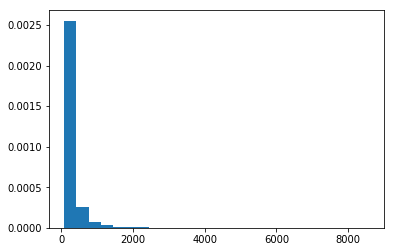

In [25]:
def plot_counts(df, pct=.25, max=10000):
    data = df.copy()
    min = data.real_counts.quantile(pct)
    print(f"Review Count .25 Quantile): {data.real_counts.quantile(.25)}")
    print(f"Observations: {len(data)}")
    data = data[data.real_counts > min]
    data = data[data.real_counts < max]
    data = data.groupby(['business_id'])['real_counts'].mean()
    plt.hist(data, bins=25, density=True)
    plt.show()
plot_counts(sorted_times)

In [26]:
sorted_times = sorted_times[sorted_times.real_counts > sorted_times.real_counts.quantile(.25)]